In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import squidpy as sq
import anndata as ad
import scipy.stats as stats
import tacco as tc
import os

/home/lagwankar/.local/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:21: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


# Sample XETG00102__0018329__lung_D239-RLL-15B3-115__20240223__200503

In [2]:
# read in matrix file
adata = sc.read_10x_h5(
    filename="/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/D239-RLL-15B3-115/cell_feature_matrix.h5")

In [3]:
# read in cells.csv
df = pd.read_csv(
    "/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/D239-RLL-15B3-115/cells.csv"
)

In [4]:
# update obs metadata with info from df
df.set_index(adata.obs_names, inplace = True)
adata.obs = df.copy()

In [5]:
adata

AnnData object with n_obs × n_vars = 344205 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
    var: 'gene_ids', 'feature_types', 'genome'

In [6]:
# storing x and y spatial coordinates of cells in anndata object 
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

In [7]:
# calculate quality control metrics and calculate cumulative sum for the top 10, 20, 50, and 150 genes
# add them to adata.obs and adata.var
sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)

## Pre-Filtering Negative Probe Count and Negative Decoding Count

In [8]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.007407421775928765
Negative Decoding Count %: 0.0033309151111889164


## Pre QC Metrics

In [9]:
total_cell_area_um2 = 	81693970.9
time_interval = 100000

In [10]:
# transcripts per 100 µm² (use cell area)
cells_per_square_micrometer = adata.obs['transcript_counts'].sum() / (total_cell_area_um2) * 100
print(f"Total number of transcripts per 100 um squared: {cells_per_square_micrometer:.2f}")

# total cells
print(f"Total number of cells: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total Transcripts: {total_high_quality_transcripts}")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
number_of_cells = adata.shape[0]
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Total number of genes per cell (avg): {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell: {median_transcripts}")

# percentage of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
print(f"Cells without transcripts: {cells_without_transcripts}")
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts: {percentage_without_transcripts:.2f}%")

Total number of transcripts per 100 um squared: 40.39
Total number of cells: 344205
Total Transcripts: 32993936
Median number of genes per cell: 33.00
Total number of genes per cell (avg): 33.12
Median transcripts per cell: 83.0
Cells without transcripts: 74
Percentage of cells without transcripts: 0.02%


## Filtering and Processing

In [11]:
# remove cells with fewer than 5 total gene counts
sc.pp.filter_cells(adata, min_counts=5)

# remove genes that are not expressed in any cell
sc.pp.filter_genes(adata, min_cells=1)

In [12]:
# normalize counts per cell, logarithmize, PCA, compute neighborhood graph
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=200)

## Initial UMAP

In [13]:
# embed the neighborhood graph of data and cluster cells into subgroups
sc.tl.umap(adata)
sc.tl.leiden(adata)

/tmp/385050.tmpdir/ipykernel_34/3901399863.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


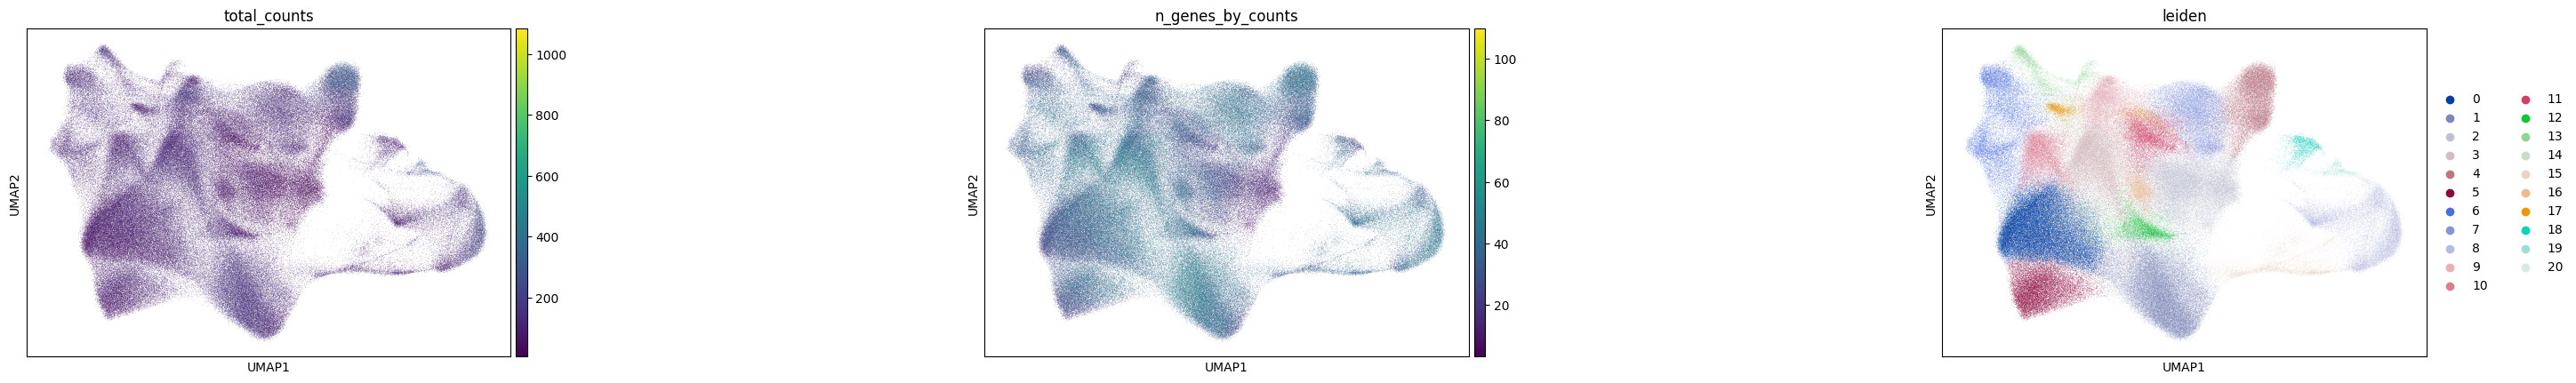

In [14]:
# umap
sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    wspace=0.8,
)

/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


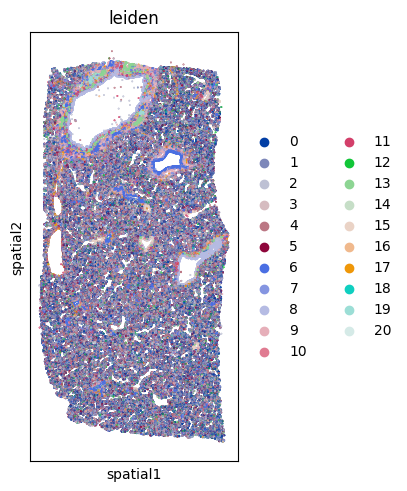

In [15]:
# spatial
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        "leiden",
    ],
    wspace=0.4,
)

## False Discovery Rate

In [16]:
# total transcript calls (TTC)
total_transcript_calls = adata.obs['total_counts'].sum()
print(f"Total Transcript Calls: {total_transcript_calls}")

# negative control calls (NCC)
negative_control_calls = adata.obs['control_probe_counts'].sum()
print(f"Total Negative Control Calls: {negative_control_calls}")

# number of negative control probes (NCPs)
number_of_negative_control_probes = 20 ## VERIFY!

# number of real gene probes (RGPs)
number_of_panel_genes = 300 ## VERIFY!

# calculate FDR (10x)
fdr_step1 = (negative_control_calls / total_transcript_calls) * (number_of_panel_genes / number_of_negative_control_probes)
FDR_1 = fdr_step1 * 100
print(f"False Discovery Rate Xenium (FDR%): {FDR_1}%")

# calculate FDR (squidpy)
FDR_2 = (negative_control_calls / total_transcript_calls) * 100
print(f"False Discovery Rate Squidpy (FDR%): {FDR_2}%")

Total Transcript Calls: 32989362.0
Total Negative Control Calls: 2439
False Discovery Rate Xenium (FDR%): 0.11089938629307229%
False Discovery Rate Squidpy (FDR%): 0.007393292419538153%


## Post-Filtering Negative Probe Count and Negative Decoding Count

In [17]:
# calculate percentage of control probes and control codewords from adata.obs
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)

print(f"Negative DNA Probe Count %: {cprobes}")
print(f"Negative Decoding Count %: {cwords}")

Negative DNA Probe Count %: 0.007393292419538153
Negative Decoding Count %: 0.0033313769450891476


## Post-QC Metrics

In [18]:
# total cells per mm2
total_cell_area_mm = total_cell_area_um2 / 1000000
cells_per_square_millimeter = len(adata.obs) / (total_cell_area_mm)
print(f"Total number of cells per square millimeter: {cells_per_square_millimeter:.2f}")

# total transcripts per cell
number_of_cells = adata.shape[0]
total_high_quality_transcripts = adata.obs['transcript_counts'].sum() / number_of_cells
print(f"Total Transcripts per cell post-QC: {total_high_quality_transcripts}")

# total cells
print(f"Total number of cells post-QC: {adata.shape[0]}")

# total high-quality decoded transcripts
total_high_quality_transcripts = adata.obs['transcript_counts'].sum()
print(f"Total number of transcripts post-QC: {total_high_quality_transcripts}")

# average area per cell
average_cell_area = adata.obs['cell_area'].mean()
print(f"Average cell area post-QC: {average_cell_area:.2f}")

# percent of cells without transcripts
cells_without_transcripts = (adata.obs['n_genes_by_counts'] == 0).sum()
total_cells = adata.shape[0]
percentage_without_transcripts = (cells_without_transcripts / total_cells) * 100
print(f"Percentage of cells without transcripts post-QC: {percentage_without_transcripts:.2f}%")

# median number of genes per cell
median_genes_per_cell = adata.obs['n_genes_by_counts'].median()
print(f"Median number of genes per cell post-QC: {median_genes_per_cell:.2f}")

# total genes per cell
total_gene_expressions = adata.obs['n_genes_by_counts'].sum()
average_genes_per_cell = total_gene_expressions / number_of_cells
print(f"Average number of genes per cell post-QC: {average_genes_per_cell:.2f}")

# median transcripts per cell
non_zero_transcripts = adata.obs[adata.obs['transcript_counts'] > 0]
median_transcripts = non_zero_transcripts['transcript_counts'].median()
print(f"Median transcripts per cell post-QC: {median_transcripts}")

Total number of cells per square millimeter: 4193.61
Total Transcripts per cell post-QC: 96.29314084058927
Total number of cells post-QC: 342593
Total number of transcripts post-QC: 32989356
Average cell area post-QC: 237.25
Percentage of cells without transcripts post-QC: 0.00%
Median number of genes per cell post-QC: 33.00
Average number of genes per cell post-QC: 33.26
Median transcripts per cell post-QC: 83.0


## Spatially Variable Genes

In [19]:
# calculate moran's I score
# I is the score, pval_norm is pvalue, var is variance, and corr_method is corrected p values
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

In [20]:
# inspect result
adata.uns["moranI"].head(10)

I  pval_norm      var_norm  pval_z_sim  pval_sim   var_sim  \
BPIFB1  0.801447        0.0  9.933422e-07         0.0  0.009901  0.000002   
MUC5B   0.766074        0.0  9.933422e-07         0.0  0.009901  0.000002   
RSPH1   0.741177        0.0  9.933422e-07         0.0  0.009901  0.000002   
PROM1   0.636943        0.0  9.933422e-07         0.0  0.009901  0.000002   
WFDC2   0.623285        0.0  9.933422e-07         0.0  0.009901  0.000002   
KRT5    0.621982        0.0  9.933422e-07         0.0  0.009901  0.000002   
FOXJ1   0.609131        0.0  9.933422e-07         0.0  0.009901  0.000002   
DTHD1   0.589063        0.0  9.933422e-07         0.0  0.009901  0.000002   
CP      0.583024        0.0  9.933422e-07         0.0  0.009901  0.000002   
CYP2F1  0.576347        0.0  9.933422e-07         0.0  0.009901  0.000002   

        pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
BPIFB1               0.0                0.0          0.01138  
MUC5B                0.0                0.0          0.01138  
RSPH1                0.0                0.0          0.01138  
PROM1                0.0                0.0          0.01138  
WFDC2                0.0                0.0          0.01138  
KRT5                 0.0                0.0          0.01138  
FOXJ1                0.0                0.0          0.01138  
DTHD1                0.0                0.0          0.01138  
CP                   0.0                0.0          0.01138  
CYP2F1               0.0                0.0          0.01138

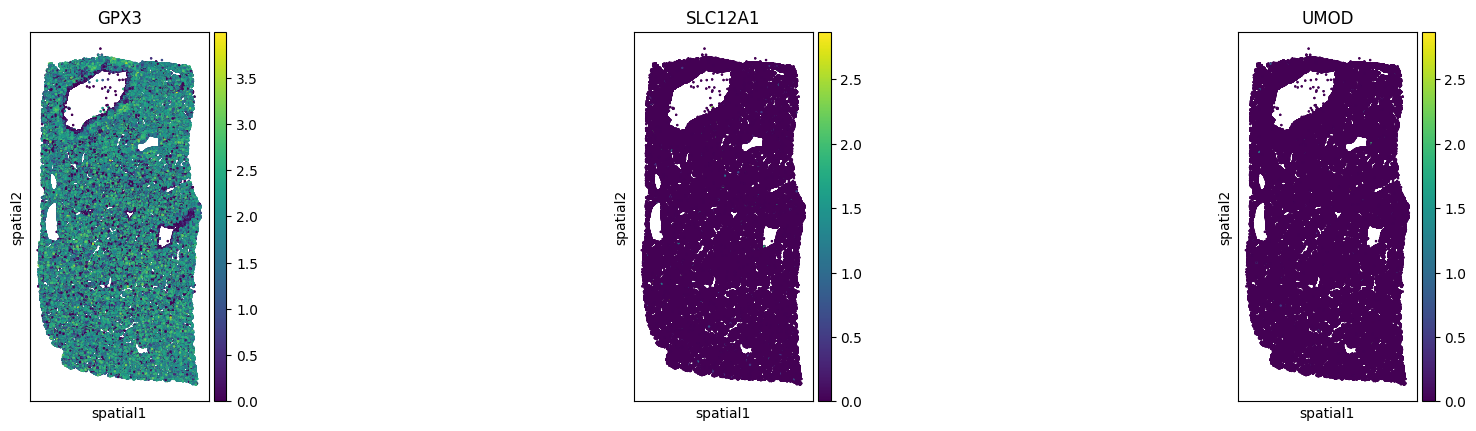

In [21]:
# plot selected highly variable genes
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    color=[
        "GPX3",
        "SLC12A1",
        "UMOD",
    ],
    shape=None,
    size=2,
    img=False,
)

## Gene Visualization

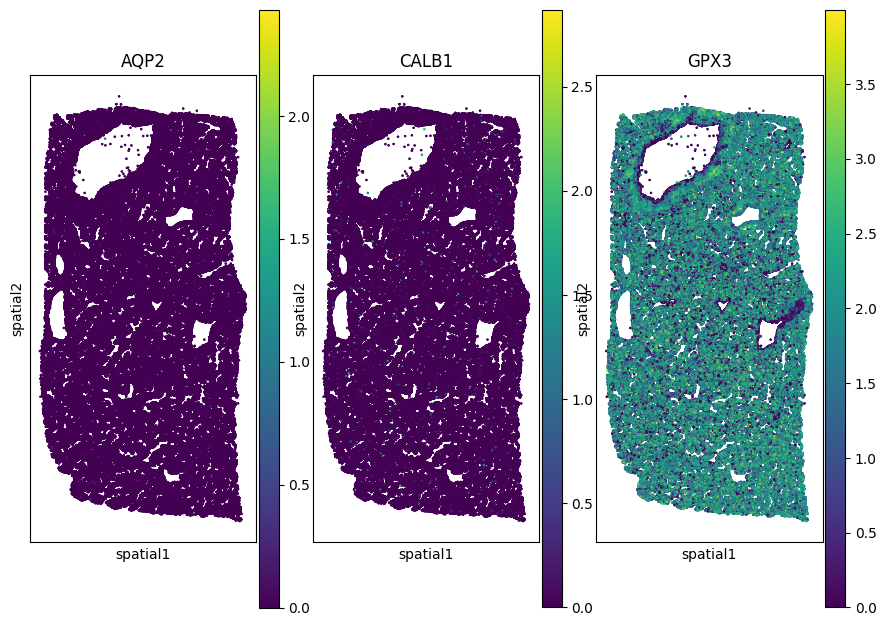

In [22]:
# visualize select genes
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "AQP2",
       "CALB1",
       "GPX3",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

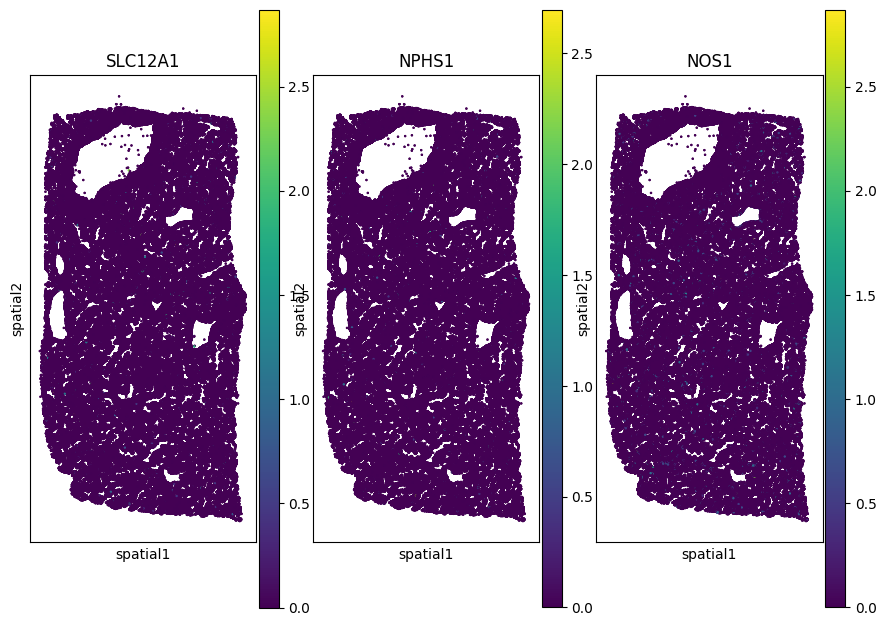

In [23]:
sq.pl.spatial_scatter(
   adata,
   library_id="spatial",
   color=[
       "SLC12A1",
       "NPHS1",
       "NOS1",
    ],
    shape=None,
    size=2,
    img=False,
    figsize=(3, 8)
)

## Import Desired Reference Object

In [24]:
# adata_5000_nodegen = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_nodegen_5kcells.h5ad")
# adata_5000 = ad.read_h5ad("/Users/stephreinert/Desktop/atlas_v2/downsampled_atlasv2_5kcells.h5ad")
adata_50prop = ad.read_h5ad("/storage1/fs1/sanjayjain/Active/CosMx/adata_Lung_LAP.h5ad")
adata_50prop

AnnData object with n_obs × n_vars = 348012 × 29800
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pagoda_k500_infomap', 'pagoda_k50_infomap', 'pagoda_k100_infomap', 'k500mod', 'subclass.l5', 'subclass.l4', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'class', 'barcode', 'UMAP_1', 'UMAP_2'
    obsm: 'X_pca', 'X_umap'

## TACCO

In [25]:
tc.tl.annotate(adata, adata_50prop, annotation_key='subclass.l1', result_key='v2.subclass.l1', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["subclass.l1"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 27.69 seconds.
Starting annotation of data with shape (342593, 297) and a reference of shape (348012, 297) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=subclass.l1, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.7674857983112933 15.7065474810481
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 10.47 seconds.

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l1'
    layers: 'counts'
    obsp: 'distances', 'connectivities', 'spatial_

In [26]:
y = adata.obsm['v2.subclass.l1']
# Find the column where the value is 1.0
y['v2.subclass.l1'] = y.idxmax(axis=1)

In [27]:
adata.obs['v2.subclass.l1'] = y['v2.subclass.l1']

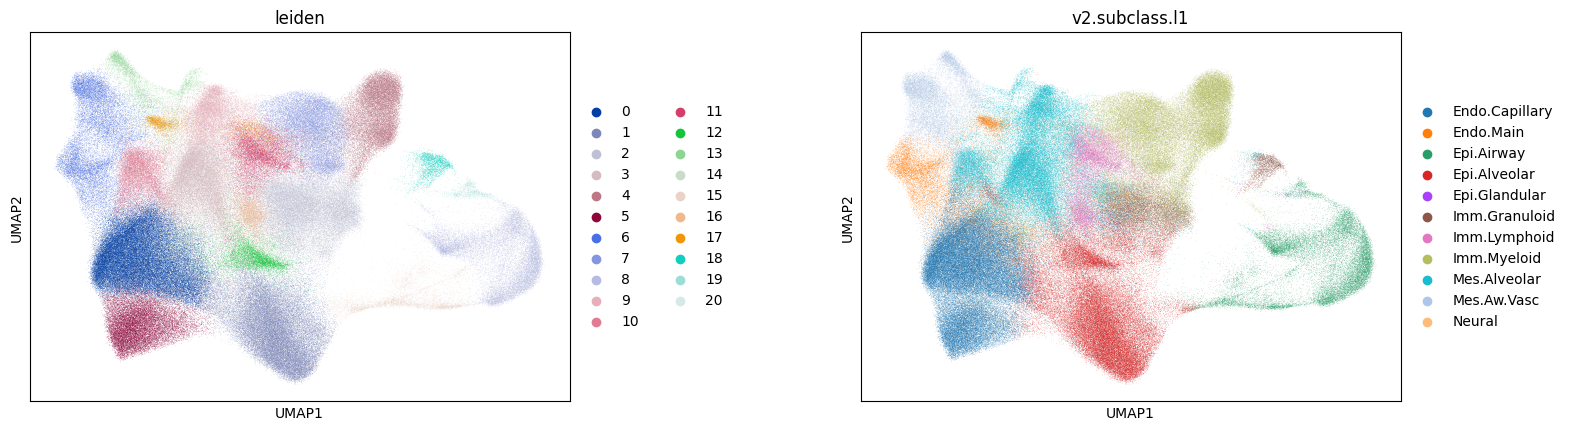

In [28]:
sc.pl.umap(
    adata,
    color=[
        "leiden",'v2.subclass.l1'
    ],
    wspace=0.4,
)

In [29]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
Endo.Capillary    76666
Epi.Alveolar      63459
Mes.Alveolar      60388
Imm.Myeloid       54942
Epi.Airway        23149
Endo.Main         21676
Imm.Lymphoid      16686
Mes.Aw.Vasc       15810
Imm.Granuloid      9187
Neural              398
Epi.Glandular       232
Name: count, dtype: int64

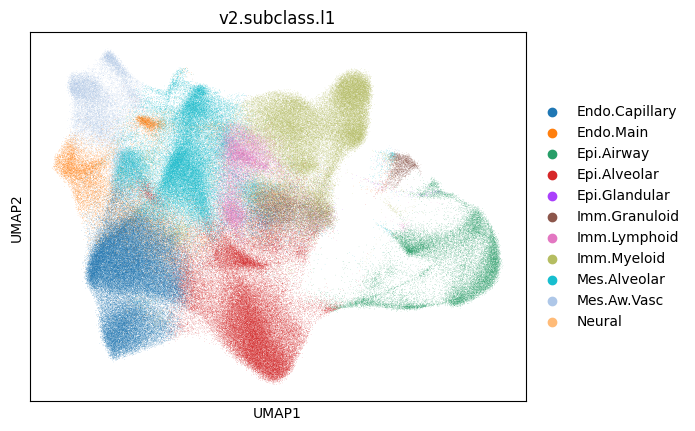

In [30]:
sc.pl.umap(adata, color=['v2.subclass.l1'], save="3781_Xen3_umap_l1.png")

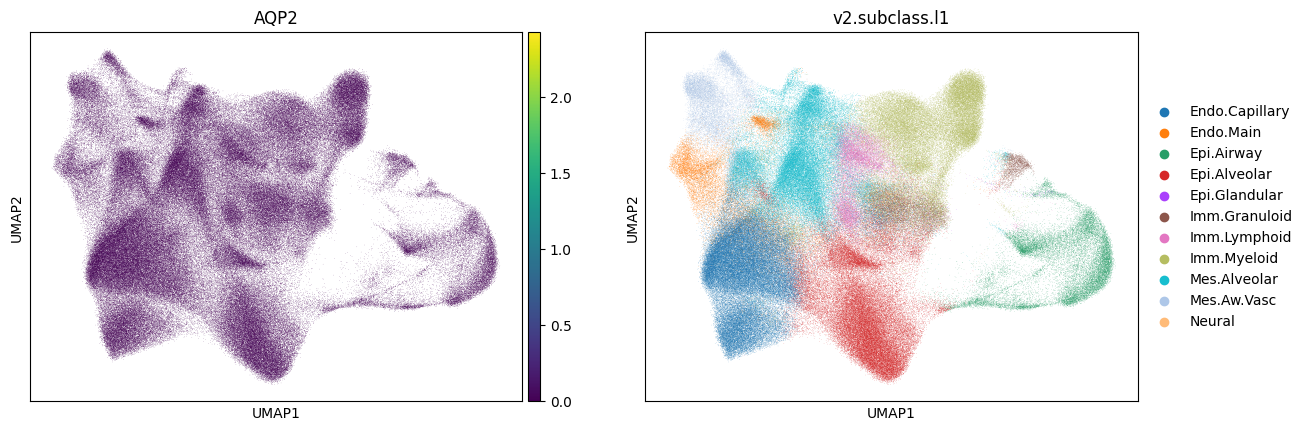

In [31]:
sc.pl.umap(adata, color=['AQP2','v2.subclass.l1'])

/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/usr/local/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


FileNotFoundError: [Errno 2] No such file or directory: '/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png'

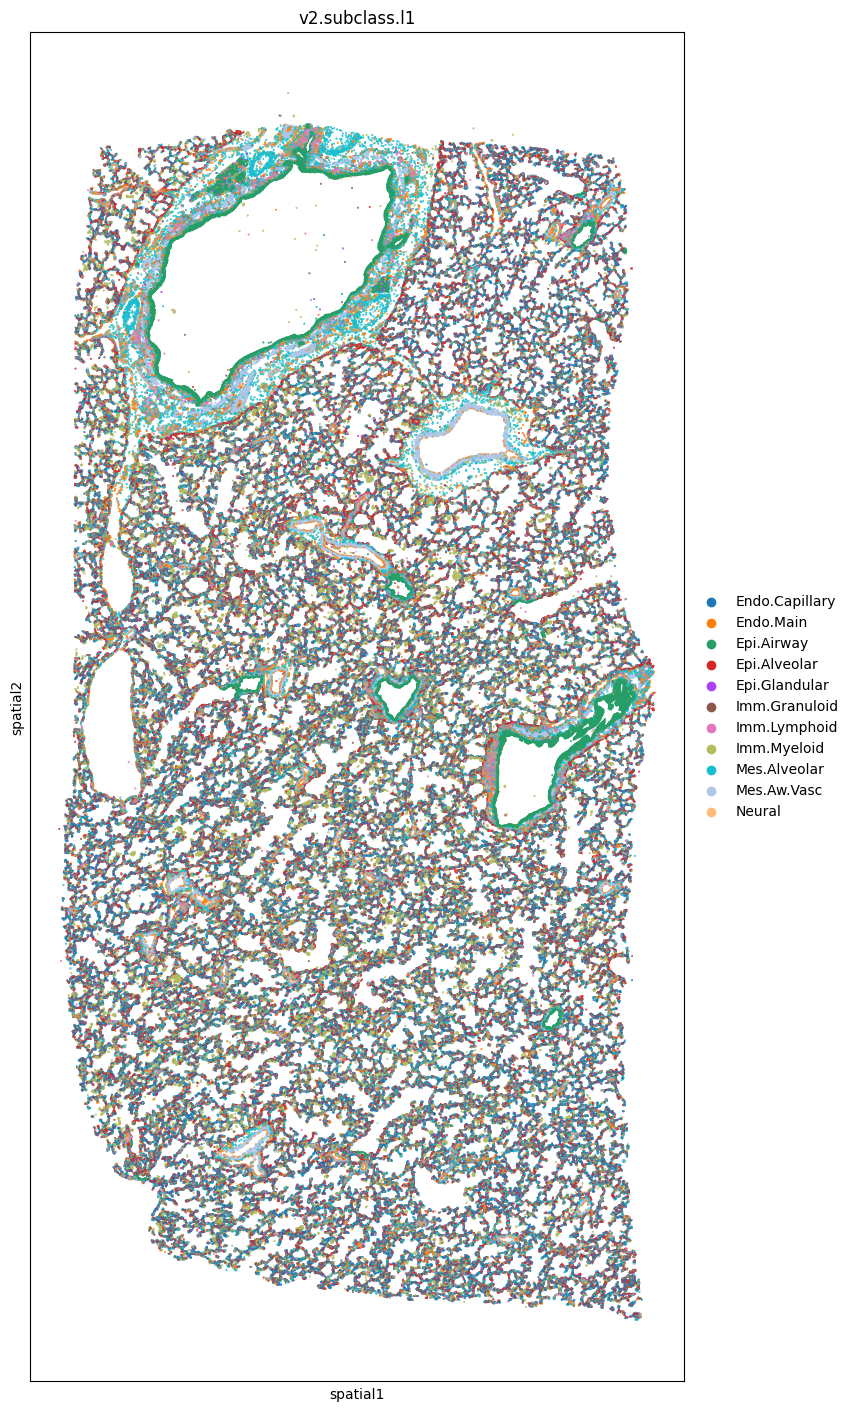

In [32]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    figsize = (16,14),
    color=[
        "v2.subclass.l1",
    ],
)

plt.savefig('/Users/stephreinert/Desktop/xenium/figures/3781_Xen3_spatial_scatter_plot.png', dpi=300, bbox_inches='tight')

In [33]:
adata.obs['v2.subclass.l1'].value_counts()

v2.subclass.l1
Endo.Capillary    76666
Epi.Alveolar      63459
Mes.Alveolar      60388
Imm.Myeloid       54942
Epi.Airway        23149
Endo.Main         21676
Imm.Lymphoid      16686
Mes.Aw.Vasc       15810
Imm.Granuloid      9187
Neural              398
Epi.Glandular       232
Name: count, dtype: int64

In [34]:
# transcript count per cell type in v2.subclass.l1
transcript_counts_per_type = adata.obs.groupby('v2.subclass.l1', observed=True)['transcript_counts'].sum()
transcript_counts_per_type_df = transcript_counts_per_type.reset_index()
transcript_counts_per_type_df = transcript_counts_per_type_df.sort_values(by='transcript_counts', ascending=False)
print(transcript_counts_per_type_df)

# save to an Excel file
#transcript_counts_per_type_df.to_excel("transcript_counts_per_cell_type_l1.xlsx", index=False# number of cells per cell type in 'v2.subclass.l1'
cell_counts_per_type = adata.obs['v2.subclass.l1'].value_counts(sort=False)
cell_counts_per_type_df = cell_counts_per_type.reset_index()
cell_counts_per_type_df.columns = ['v2.subclass.l1', 'cell_count']

# proportion of cells per cell type in 'v2.subclass.l1'
cell_proportion_per_type = adata.obs['v2.subclass.l1'].value_counts(normalize=True, sort=False) * 100
cell_proportion_per_type_df = cell_proportion_per_type.reset_index()
cell_proportion_per_type_df.columns = ['v2.subclass.l1', 'proportion (%)']

# merge 
cell_counts_and_proportions_df = pd.merge(cell_counts_per_type_df, cell_proportion_per_type_df, on='v2.subclass.l1')

# sort and print
cell_counts_and_proportions_df = cell_counts_and_proportions_df.sort_values(by='cell_count', ascending=False)
print(cell_counts_and_proportions_df)

# save to excel
output_file_path = "/Users/stephreinert/Desktop/xenium/stats/3781_Xen3_subclass_counts_l1.xlsx"
cell_counts_and_proportions_df.to_excel(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")

    v2.subclass.l1  transcript_counts
3     Epi.Alveolar            7040190
7      Imm.Myeloid            6279477
8     Mes.Alveolar            6078785
0   Endo.Capillary            5890795
2       Epi.Airway            2921590
1        Endo.Main            1731441
9      Mes.Aw.Vasc            1629935
6     Imm.Lymphoid             954311
5    Imm.Granuloid             422765
10          Neural              22015
4    Epi.Glandular              18052
    v2.subclass.l1  cell_count  proportion (%)
0   Endo.Capillary       76666       22.378157
3     Epi.Alveolar       63459       18.523146
8     Mes.Alveolar       60388       17.626747
7      Imm.Myeloid       54942       16.037105
2       Epi.Airway       23149        6.756997
1        Endo.Main       21676        6.327041
6     Imm.Lymphoid       16686        4.870502
9      Mes.Aw.Vasc       15810        4.614805
5    Imm.Granuloid        9187        2.681608
10          Neural         398        0.116173
4    Epi.Glandular         

OSError: Cannot save file into a non-existent directory: '/Users/stephreinert/Desktop/xenium/stats'

## Add Metadata

In [35]:
adata.obs['PPID'] = 'D239'
adata.obs['Condition'] = 'Ref'
adata.obs['Tissue'] = 'Lung'

In [36]:
adata

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'hvg', 'umap', 'leiden', 'leiden_colors', 'spatial_neighbors', 'moranI', 'v2.subclass.l1_colors'
    obsm: 'spatial', 'X_pca', 'X_umap', 'v2.subclass.l1'
    varm: 'PCs', 'v2.subclass.l

## Save Object

In [37]:
# remove a specific key from the obsm attribute, e.g., 'v2.subclass.l1'
del adata.obsm['v2.subclass.l1']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l1']


In [38]:
adata.write_h5ad("/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/D239-RLL-15B3-115/D239_Xen_obj.h5ad")

In [40]:
adata= sc.read_h5ad("/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/D239-RLL-15B3-115/D239_Xen_obj.h5ad")

In [41]:
tc.tl.annotate(adata, adata_50prop, annotation_key='subclass.l2', result_key='v2.subclass.l2', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["subclass.l2"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 33.2 seconds.
Starting annotation of data with shape (342593, 297) and a reference of shape (348012, 297) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=subclass.l2, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.7674857983112933 15.7065474810481
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 20.42 seconds.


AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'v2.subclass.l1_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'v2.subclass.l2'
    varm: 'PCs', 'v2.subclass.l

In [42]:
tc.tl.annotate(adata, adata_50prop, annotation_key='subclass.l3', result_key='v2.subclass.l3', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["subclass.l3"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 35.79 seconds.
Starting annotation of data with shape (342593, 297) and a reference of shape (348012, 297) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=subclass.l3, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.7674857983112933 15.7065474810481
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 25.49 seconds.

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'v2.subclass.l1_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'v2.subclass.l2', 'v2.subclass.l3'
    varm: 'PC

In [43]:
tc.tl.annotate(adata, adata_50prop, annotation_key='subclass.l4', result_key='v2.subclass.l4', assume_valid_counts=True,max_annotation = 1)

Starting preprocessing
Annotation profiles were not found in `reference.varm["subclass.l4"]`. Constructing reference profiles with `tacco.preprocessing.construct_reference_profiles` and default arguments...
Finished preprocessing in 37.9 seconds.
Starting annotation of data with shape (342593, 297) and a reference of shape (348012, 297) using the following wrapped method:
+- maximum annotation: max_annotation=1
   +- platform normalization: platform_iterations=0, gene_keys=subclass.l4, normalize_to=adata
      +- multi center: multi_center=None multi_center_amplitudes=True
         +- bisection boost: bisections=4, bisection_divisor=3
            +- core: method=OT annotation_prior=None
mean,std( rescaling(gene) )  2.7674857983112933 15.7065474810481
bisection run on 1
bisection run on 0.6666666666666667
bisection run on 0.4444444444444444
bisection run on 0.2962962962962963
bisection run on 0.19753086419753085
bisection run on 0.09876543209876543
Finished annotation in 30.13 seconds.


AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'v2.subclass.l1_colors'
    obsm: 'X_pca', 'X_umap', 'spatial', 'v2.subclass.l2', 'v2.subclass.l3', 'v2.subclass

In [44]:
y = adata.obsm['v2.subclass.l2']
# Find the column where the value is 1.0
y['v2.subclass.l2'] = y.idxmax(axis=1) 
adata.obs['v2.subclass.l2'] = y['v2.subclass.l2'] 
del adata.obsm['v2.subclass.l2']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l2']


In [45]:
y = adata.obsm['v2.subclass.l3']
# Find the column where the value is 1.0
y['v2.subclass.l3'] = y.idxmax(axis=1) 
adata.obs['v2.subclass.l3'] = y['v2.subclass.l3'] 
del adata.obsm['v2.subclass.l3']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l3']


In [46]:
y = adata.obsm['v2.subclass.l4']
# Find the column where the value is 1.0
y['v2.subclass.l4'] = y.idxmax(axis=1) 
adata.obs['v2.subclass.l4'] = y['v2.subclass.l4'] 
del adata.obsm['v2.subclass.l4']

# remove a specific key from the varm attribute, e.g., 'v2.subclass.l1'
del adata.varm['v2.subclass.l4']


In [47]:
adata

AnnData object with n_obs × n_vars = 342593 × 300
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'leiden', 'v2.subclass.l1', 'PPID', 'Condition', 'Tissue', 'v2.subclass.l2', 'v2.subclass.l3', 'v2.subclass.l4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'v2.subclass.l1_colors'
    obsm: 'X_pca', 'X_umap', 'spat

In [48]:
adata.write_h5ad("/storage1/fs1/sanjayjain/Active/Xenium/Data/IntegratedST_Xenium_Data/D239-RLL-15B3-115/D239_Xen_obj.h5ad")